<center><a href="https://wangyu16.github.io/PolymerScienceEducation/"><img src="https://raw.githubusercontent.com/wangyu16/PolymerScienceEducation/master/Fig/Logo_black.svg" width='150' /></a></center>

# Single Chain Conformation

-----------

To learn the background knowledge, please visit this [study guide]().

##  What does this simulator do and how to use it?

### Definitions

A chain consists of a sequence of $(n+1)$ points in 3D space, where:

* There are $n$ bond vectors connecting adjacent points. In this simulation, all bond vectors have a unit length.
* $(n−1)$ bond angles ($\theta$) represent the angles between adjacent bonds. Alternatively, you can calculate a bond angle as $\pi$ minus the angle between two adjacent bond vectors.
* $(n−2)$ torsion angles ($\phi$) are defined by three adjacent bonds labeled as $(i−1)$, $i$, and $(i+1)$. Specifically:
  * Bonds $(i−1)$ and $i$ define a plane A.
  * Bonds $i$ and $(i+1)$ define a plane B.
  * The dihedral angle between plane A and plane B is the torsion angle.

To visualize this, imagine a model chain resembling polyethylene, where C atoms represent the points constructing the chain, and H atoms are omitted.

### What does this simulator do?

Given chain length (the number of bonds $n$ in each chain),
1. generate chains based on three different models: freely hinged, freely rotation, and hindered rotation;  
2. calculate end to end distances $h$ and radius of gyrations ($R_g$) for each chain;  
3. plot the distributions of $h$ and $R_g$, and calculate the mean values of $\langle h^2\rangle$ and $\langle R_g^2\rangle$.  

### How to use it?

Simply set the values in "Section 2. Simulation conditions" and run all cells. The results will show sample polymer chains, the distribution of ene-to-end distance, and the distribution of radii of gyration.

In [ ]:
#@title 1. Install and import packages {display-mode: "form" }
%%capture
import plotly.graph_objs as go
from plotly.subplots import make_subplots
from matplotlib import pyplot as plt
plt.style.use('fivethirtyeight')
import numpy as np
import pandas as pd
from scipy.optimize import curve_fit
import concurrent.futures
!pip install sigfig
from sigfig import round

In [ ]:
#@title 2. Simulation conditions. {display-mode: "form" }
#@markdown Please select the conditions you want to simulate.

chainType = "freely rotation" #@param ["freely hinged", "freely rotation", "hindered rotation"]

#@markdown For a freely hinged chain the bondAngle parameter does not do anything. \\
#@markdown For other types of chains with constant bond angles you can specify the value. \\
#@markdown The default value 109.5 is the bond angle found in polyethylene.
bondAngle = 109.5 #@param {type:"slider", min:90, max:175, step:0.1}
#@markdown The value of chainLength defines the number of bonds in each chain.
chainLength = 268 #@param {type:"slider", min:25, max:900, step:1}

numberOfChains = 5000

temperature = 298 # K
NA = 6.02e23 # Avogadro constant (/mol)
k = 1.38e-23 # Boltzmann constant (J/K)
# Energy levels associated with each degree of torsion angle.
ELevels = np.array([2.47483009e+01, 2.46863103e+01, 2.45947570e+01, 2.44739881e+01,
       2.43243505e+01, 2.41461913e+01, 2.39398574e+01, 2.37056959e+01,
       2.34440537e+01, 2.31552777e+01, 2.28397151e+01, 2.24977128e+01,
       2.21296178e+01, 2.17357771e+01, 2.13165376e+01, 2.08722464e+01,
       2.04032505e+01, 1.99098968e+01, 1.93925323e+01, 1.88515041e+01,
       1.82872822e+01, 1.77019281e+01, 1.70986122e+01, 1.64805274e+01,
       1.58508664e+01, 1.52128221e+01, 1.45695873e+01, 1.39243549e+01,
       1.32803176e+01, 1.26406685e+01, 1.20086002e+01, 1.13873056e+01,
       1.07799775e+01, 1.01898089e+01, 9.61999247e+00, 9.07372111e+00,
       8.55413894e+00, 8.06271625e+00, 7.59886814e+00, 7.16188370e+00,
       6.75105206e+00, 6.36566231e+00, 6.00500357e+00, 5.66836495e+00,
       5.35503554e+00, 5.06430447e+00, 4.79546083e+00, 4.54779374e+00,
       4.32059231e+00, 4.11314564e+00, 3.92474283e+00, 3.75467301e+00,
       3.60222527e+00, 3.46668873e+00, 3.34735249e+00, 3.24350566e+00,
       3.15443734e+00, 3.07943666e+00, 3.01783962e+00, 2.96932938e+00,
       2.93374482e+00, 2.91092555e+00, 2.90071119e+00, 2.90294137e+00,
       2.91745569e+00, 2.94409379e+00, 2.98269527e+00, 3.03309976e+00,
       3.09514688e+00, 3.16867625e+00, 3.25352747e+00, 3.34954018e+00,
       3.45655399e+00, 3.57440853e+00, 3.70294340e+00, 3.84199823e+00,
       3.99141264e+00, 4.15102624e+00, 4.32067866e+00, 4.50020951e+00,
       4.68945841e+00, 4.88826499e+00, 5.09646885e+00, 5.31390962e+00,
       5.54042692e+00, 5.77586037e+00, 6.02004959e+00, 6.27283418e+00,
       6.53405378e+00, 6.80354801e+00, 7.08115647e+00, 7.36670850e+00,
       7.65959320e+00, 7.95860333e+00, 8.26248925e+00, 8.57000130e+00,
       8.87988984e+00, 9.19090523e+00, 9.50179781e+00, 9.81131794e+00,
       1.01182160e+01, 1.04212423e+01, 1.07191471e+01, 1.10106810e+01,
       1.12945942e+01, 1.15696370e+01, 1.18345599e+01, 1.20881131e+01,
       1.23290470e+01, 1.25561121e+01, 1.27680585e+01, 1.29636368e+01,
       1.31415972e+01, 1.33006901e+01, 1.34396658e+01, 1.35572834e+01,
       1.36529467e+01, 1.37271369e+01, 1.37804378e+01, 1.38134329e+01,
       1.38267062e+01, 1.38208411e+01, 1.37964215e+01, 1.37540310e+01,
       1.36942534e+01, 1.36175417e+01, 1.35237754e+01, 1.34126761e+01,
       1.32839655e+01, 1.31373654e+01, 1.29725974e+01, 1.27893832e+01,
       1.25874446e+01, 1.23665032e+01, 1.21262807e+01, 1.18664989e+01,
       1.15868794e+01, 1.12872563e+01, 1.09686939e+01, 1.06330149e+01,
       1.02820533e+01, 9.91764319e+00, 9.54161852e+00, 9.15581330e+00,
       8.76206154e+00, 8.36219723e+00, 7.95805439e+00, 7.55146701e+00,
       7.14426909e+00, 6.73829465e+00, 6.33537767e+00, 5.93735218e+00,
       5.54605216e+00, 5.16331162e+00, 4.79096456e+00, 4.43084499e+00,
       4.08447295e+00, 3.75214995e+00, 3.43388198e+00, 3.12967501e+00,
       2.83953501e+00, 2.56346797e+00, 2.30147984e+00, 2.05357661e+00,
       1.81976426e+00, 1.60004875e+00, 1.39443605e+00, 1.20293216e+00,
       1.02554303e+00, 8.62274640e-01, 7.13132969e-01, 5.78123989e-01,
       4.57253674e-01, 3.50527998e-01, 2.57952936e-01, 1.79534461e-01,
       1.15278548e-01, 6.51911715e-02, 2.92783051e-02, 7.54592315e-03,
       0.00000000e+00, 7.54592315e-03, 2.92783051e-02, 6.51911715e-02,
       1.15278548e-01, 1.79534461e-01, 2.57952936e-01, 3.50527998e-01,
       4.57253674e-01, 5.78123989e-01, 7.13132969e-01, 8.62274640e-01,
       1.02554303e+00, 1.20293216e+00, 1.39443605e+00, 1.60004875e+00,
       1.81976426e+00, 2.05357661e+00, 2.30147984e+00, 2.56346797e+00,
       2.83953501e+00, 3.12967501e+00, 3.43388198e+00, 3.75214995e+00,
       4.08447295e+00, 4.43084499e+00, 4.79096456e+00, 5.16331162e+00,
       5.54605216e+00, 5.93735218e+00, 6.33537767e+00, 6.73829465e+00,
       7.14426909e+00, 7.55146701e+00, 7.95805439e+00, 8.36219723e+00,
       8.76206154e+00, 9.15581330e+00, 9.54161852e+00, 9.91764319e+00,
       1.02820533e+01, 1.06330149e+01, 1.09686939e+01, 1.12872563e+01,
       1.15868794e+01, 1.18664989e+01, 1.21262807e+01, 1.23665032e+01,
       1.25874446e+01, 1.27893832e+01, 1.29725974e+01, 1.31373654e+01,
       1.32839655e+01, 1.34126761e+01, 1.35237754e+01, 1.36175417e+01,
       1.36942534e+01, 1.37540310e+01, 1.37964215e+01, 1.38208411e+01,
       1.38267062e+01, 1.38134329e+01, 1.37804378e+01, 1.37271369e+01,
       1.36529467e+01, 1.35572834e+01, 1.34396658e+01, 1.33006901e+01,
       1.31415972e+01, 1.29636368e+01, 1.27680585e+01, 1.25561121e+01,
       1.23290470e+01, 1.20881131e+01, 1.18345599e+01, 1.15696370e+01,
       1.12945942e+01, 1.10106810e+01, 1.07191471e+01, 1.04212423e+01,
       1.01182160e+01, 9.81131794e+00, 9.50179781e+00, 9.19090523e+00,
       8.87988984e+00, 8.57000130e+00, 8.26248925e+00, 7.95860333e+00,
       7.65959320e+00, 7.36670850e+00, 7.08115647e+00, 6.80354801e+00,
       6.53405378e+00, 6.27283418e+00, 6.02004959e+00, 5.77586037e+00,
       5.54042692e+00, 5.31390962e+00, 5.09646885e+00, 4.88826499e+00,
       4.68945841e+00, 4.50020951e+00, 4.32067866e+00, 4.15102624e+00,
       3.99141264e+00, 3.84199823e+00, 3.70294340e+00, 3.57440853e+00,
       3.45655399e+00, 3.34954018e+00, 3.25352747e+00, 3.16867625e+00,
       3.09514688e+00, 3.03309976e+00, 2.98269527e+00, 2.94409379e+00,
       2.91745569e+00, 2.90294137e+00, 2.90071119e+00, 2.91092555e+00,
       2.93374482e+00, 2.96932938e+00, 3.01783962e+00, 3.07943666e+00,
       3.15443734e+00, 3.24350566e+00, 3.34735249e+00, 3.46668873e+00,
       3.60222527e+00, 3.75467301e+00, 3.92474283e+00, 4.11314564e+00,
       4.32059231e+00, 4.54779374e+00, 4.79546083e+00, 5.06430447e+00,
       5.35503554e+00, 5.66836495e+00, 6.00500357e+00, 6.36566231e+00,
       6.75105206e+00, 7.16188370e+00, 7.59886814e+00, 8.06271625e+00,
       8.55413894e+00, 9.07372111e+00, 9.61999247e+00, 1.01898089e+01,
       1.07799775e+01, 1.13873056e+01, 1.20086002e+01, 1.26406685e+01,
       1.32803176e+01, 1.39243549e+01, 1.45695873e+01, 1.52128221e+01,
       1.58508664e+01, 1.64805274e+01, 1.70986122e+01, 1.77019281e+01,
       1.82872822e+01, 1.88515041e+01, 1.93925323e+01, 1.99098968e+01,
       2.04032505e+01, 2.08722464e+01, 2.13165376e+01, 2.17357771e+01,
       2.21296178e+01, 2.24977128e+01, 2.28397151e+01, 2.31552777e+01,
       2.34440537e+01, 2.37056959e+01, 2.39398574e+01, 2.41461913e+01,
       2.43243505e+01, 2.44739881e+01, 2.45947570e+01, 2.46863103e+01]) # kJ/mo

# plt.plot(ELevels)
# plt.show()


In [ ]:
# @title {display-mode: "form" }

class chain:
  """
  A class to represent a chain of n points in 3D space.
  """

  def __init__(self, points):
    """
    Initialize a chain object.
    Args:
      points: A series of n points in 3D space with their coordinates stored in a (n, 3) numpy array.
    """
    self.coordinates = points
    # Calculate the end-to-end distance.
    self.e2eDistance = np.linalg.norm(self.coordinates[-1] - self.coordinates[0])
    # Calculate the pairwise distances of all points and save in a (n, n) array.
    # self.distances = np.linalg.norm(self.coordinates.T[:, :, None] - self.coordinates.T[:, None, :], axis=0)
    # Calculate the radius of gyration from pairwise distances.
    #self.radiusGyration_alt = np.sqrt(np.mean(self.distances**2)/2)

  @property
  def radiusGyration(self):
    """
    An alternative way to calculates the radius of gyration of the chain.
    Returns:
      The radius of gyration.
    """
    centerOfMass = np.mean(self.coordinates, axis=0)
    squaredDistances = np.sum((self.coordinates - centerOfMass)**2, axis=1)
    return np.sqrt(np.mean(squaredDistances))

  @classmethod
  def fromAngles(cls, thetas, phis, chainLength):
    """
    An alternative constructor from given bond angles and torsion angles.
    Args:
      thetas: bond angles
      phis: torsion angles
      chainLength: number of bonds in each chain
    Returns:
      A chain object.
    """
    def rotateVectorZ(vectors, phi):
      """
      Rotate the vectors anticlockwise around z axis.
      Args:
        vectors: (3, n) array which contains n 3D vectors.
        phi: rotation angle in radians.
      Returns: (3, n) array which contains n 3D vectors rotated anticlockwise around z axis.
      """
      rotationMatrix = np.array([[np.cos(phi), -np.sin(phi), 0],
                                [np.sin(phi), np.cos(phi), 0],
                                [0, 0, 1]])
      return np.matmul(rotationMatrix, vectors)

    def rotateVectorY(vectors, theta):
      """
      Rotate the vectors anticlockwise around y axis.
      Args:
        vectors: (3, n) array which contains n 3D vectors.
        theta: rotation angle in radians.
      Returns: (3, n) array which contains n 3D vectors rotated anticlockwise around y axis.
      """
      rotationMatrix = np.array([[np.cos(theta), 0, np.sin(theta)],
                                [0, 1, 0],
                                [-np.sin(theta), 0, np.cos(theta)]])
      return np.matmul(rotationMatrix, vectors)
    points = np.array([[0],[0],[0]])
    for i in range(chainLength):
      points = np.append(points, np.array([[0],[0],[1]]), axis = 1)
      points = points - np.array([[0],[0],[1]])
      points = rotateVectorY(points, thetas[i] - np.pi)
      points = rotateVectorZ(points, phis[i])
    points = points.T
    points = points + 2*np.sqrt(chainLength)*np.random.rand(3)
    return cls(points)

def gaussian(x, amplitude, mean, stddev):
  return amplitude * np.exp(-((x - mean) / 4 / stddev)**2)

# Generate bond angles and torsion angles based on the chain model.
if chainType == "freely hinged":
  # Freely hinged chains have random bond angles.
  thetas = np.random.uniform(0, np.pi, size = (numberOfChains, chainLength))
else:
  # All other types have constant bond angles.
  thetas = bondAngle/180*np.pi*np.ones((numberOfChains, chainLength))

if chainType == "hindered rotation":
  # The relative probability of two energy levels is calculated based on Boltzmann distribution.
  relativeProbs = np.exp(-1000*ELevels/NA/temperature/k)
  probs = relativeProbs/relativeProbs.sum() # Normalized probabilities
  # Hindered rotation chains have torsion angles depend on the conformational energy.
  # The conformaitonal energy is calculated from butane.
  phis = np.random.choice(np.arange(360), size = (numberOfChains, chainLength), p = probs)
  phis = np.pi/180*phis
else:
  # All other types have random torsion angles.
  phis = np.random.uniform(0, 2*np.pi, size = (numberOfChains, chainLength))

#plt.hist(phis, bins=50)
#plt.show()

In [ ]:
# @title 3. Simulation {display-mode: "form"}
%%time
chainList = []
with concurrent.futures.ProcessPoolExecutor(max_workers=4) as executor:
    # Submit tasks and store futures
    futures = {executor.submit(chain.fromAngles, thetas[i], phis[i], chainLength): i for i in range(numberOfChains)}

    for future in concurrent.futures.as_completed(futures):
        i = futures[future]  # Get the index associated with the completed future
        try:
            chainInstance = future.result()  # Get the result of the completed future
            # Process the result (e.g., export, analyze)
            chainList.append({
                'coordiantes': chainInstance.coordinates,
                'e2eDistance': chainInstance.e2eDistance,
                'radiusGyration': chainInstance.radiusGyration
            })
            del futures[future]  # Delete the future to release resources
            del chainInstance  # Explicitly delete the chainInstance object
        except Exception as e:
            print(f"Task {i} generated an exception: {e}")

chains = pd.DataFrame(chainList)
del chainList

CPU times: user 4.37 s, sys: 770 ms, total: 5.14 s
Wall time: 1min 28s


## 4. Results

In [ ]:
# @title Show sample chains {display-mode:"form"}
# @markdown Run this cell again to sample different chains.

def showChains(chains, n=5):
  """
  Plot a number of chains.
  Args:
    chains:
    n: the number of chains to be ploted.
  """
  if n > len(chains):
    print(f"You cannot show {n} chains because the number of chains is less than {n}.")
    n = min([10, len(chains)])
  elif n > 10:
    print(f"Showing too many chains will make it to crowd to see the details.")
    n = 10
  fig = make_subplots(rows=1, cols=1)
  idxs = np.random.randint(len(chains), size = n)
  for idx in idxs:
    fig.add_trace(go.Scatter3d(x=chains[idx].T[0], y=chains[idx].T[1], z=chains[idx].T[2], mode='lines+markers', marker=dict(size=3)))
  fig.update_layout(width=1200, height=800, scene=dict(aspectmode='cube'))
  fig.show()


showChains(chains['coordiantes'], n = 5)
# You can set the number between 1 and 10, which is how many chains to be shown in the figure.
# You can run this cell again to sample different chains.

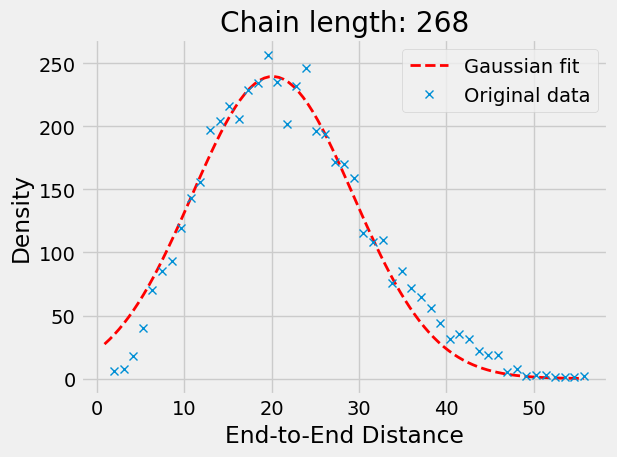

The root mean square value of the end-to-end distance is 23.21.


In [ ]:
# @title End-to-End Distance {display-mode: "form" }

hist, bin_edges = np.histogram(chains['e2eDistance'], bins=50)
bin_centers = 0.5 * (bin_edges[:-1] + bin_edges[1:])
initial_guess = [1, np.mean(bin_centers), np.std(bin_centers)]
popt, pcov = curve_fit(gaussian, bin_centers, hist, p0=initial_guess)
x_fit = np.linspace(bin_edges[0], bin_edges[-1], 100)
y_fit = gaussian(x_fit, *popt)
plt.plot(x_fit, y_fit, 'r--', linewidth=2, label='Gaussian fit')
plt.plot(bin_edges[1:], hist, 'x', label='Original data')
plt.xlabel('End-to-End Distance')
plt.ylabel('Density')
plt.title(f"Chain length: {chainLength}")
plt.legend()
plt.tight_layout()
plt.show()

# print(f"The mean value of the end-to-end distance is {round(chains['e2eDistance'].mean(), sigfigs = 4)}.")
# print(f"The standard deviation of the end-to-end distance is {round(chains['e2eDistance'].std(), sigfigs = 4)}.")
print(f"The root mean square value of the end-to-end distance is {round(np.sqrt((chains['e2eDistance']**2).mean()), sigfigs = 4)}.")

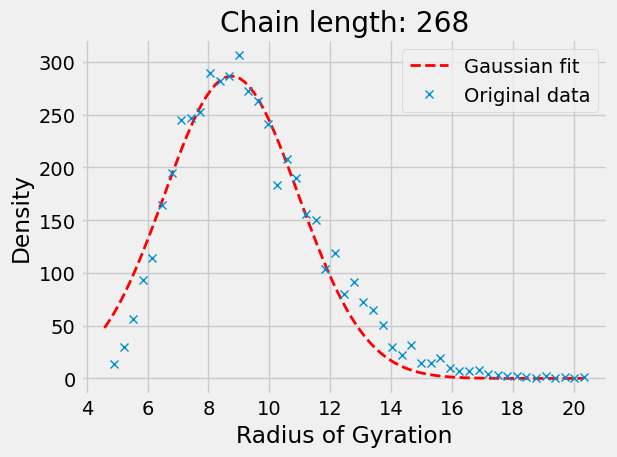

The root mean square value of the radius of gyration is 9.485.


In [ ]:
# @title Radius of Gyration {display-mode: "form" }

hist, bin_edges = np.histogram(chains['radiusGyration'], bins=50)
bin_centers = 0.5 * (bin_edges[:-1] + bin_edges[1:])
initial_guess = [1, np.mean(bin_centers), np.std(bin_centers)]
popt, pcov = curve_fit(gaussian, bin_centers, hist, p0=initial_guess)
x_fit = np.linspace(bin_edges[0], bin_edges[-1], 100)
y_fit = gaussian(x_fit, *popt)
plt.plot(x_fit, y_fit, 'r--', linewidth=2, label='Gaussian fit')
plt.plot(bin_edges[1:], hist, 'x', label='Original data')
plt.xlabel('Radius of Gyration')
plt.ylabel('Density')
plt.title(f"Chain length: {chainLength}")
plt.legend()
plt.tight_layout()
plt.show()

# print(f"The mean value of the radius of gyration is {round(chains['radiusGyration'].mean(), sigfigs = 4)}.")
# print(f"The standard deviation of the radius of gyration is {round(chains['radiusGyration'].std(), sigfigs = 4)}.")
print(f"The root mean square value of the radius of gyration is {round(np.sqrt((chains['radiusGyration']**2).mean()), sigfigs = 4)}.")



---



In [2]:
#@title Copyright { display-mode: "form" }
import requests
from IPython.display import Markdown
copyright = requests.get("https://raw.githubusercontent.com/wangyu16/PolymerScienceEducation/master/copyright.md")
Markdown(copyright.text)

---

### MIT License  

Copyright (c) 2021 -- 2024 Yu Wang

Permission is hereby granted, free of charge, to any person obtaining a copy of this software and associated documentation files (the “Software”), to deal in the Software without restriction, including without limitation the rights to use, copy, modify, merge, publish, distribute, sublicense, and/or sell copies of the Software, and to permit persons to whom the Software is furnished to do so, subject to the following conditions:

The above copyright notice and this permission notice shall be included in all copies or substantial portions of the Software.

THE SOFTWARE IS PROVIDED “AS IS”, WITHOUT WARRANTY OF ANY KIND, EXPRESS OR IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY, FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE SOFTWARE.

### Contact

Dr. Yu Wang  
Department of Chemistry  
Institute for Materials Research and Innovation  
University of Louisiana at Lafayette  
Lafayette, LA 70504  
Email: yuwang@louisiana.edu

### Acknowledgement

This project is sponsored by National Science Foundation (NSF-2142043). 


In [3]:
# @title {display-mode: "form" }
links = requests.get("https://raw.githubusercontent.com/wangyu16/PolymerScienceEducation/refs/heads/master/links.md")
Markdown(links.text)

---

### Links

**[Home page of OVESET](https://wangyu16.github.io/PolymerScienceEducation/):** 

<img src="https://raw.githubusercontent.com/wangyu16/PolymerScienceEducation/refs/heads/master/img/QR_OVESET.svg" alt="OVESET Home Page" width="300">

**[Home page of Study Guide](https://hackmd.io/@YW2025/HJLiqoHRR)**

<img src="https://raw.githubusercontent.com/wangyu16/PolymerScienceEducation/refs/heads/master/img/QR_PolymerStudyGuide.svg" alt="Introduction to Polymer Science" width="300">

